In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import nnls
import matplotlib.pyplot as plt

from StateData import StateData

In [2]:
State_Names = ['Vermont','Wyoming','California','California Simulated']

Policy_types = ['No_Intervention','All_policies','Case_Isolation','Household_Quarantine',\
                'Place_Closure','Social_Distancing']

### Objective
We are working with actual california dataset generated using UK group's model
1. We are calculating A matrix parameters for different phases. <br>
2. We have to find difference between these A matrices <br>


In [3]:
state_name = State_Names[2]

Cal_data = StateData(state_name)

We got <b>Cal_data</b> object by using StateData class. <br>
We get values of following 4 variables from the object <br>
<br>
<b>orig_beta_data</b> : daywise cummulative number of infected cases for different age groups<br>
<b>S_0</b> : Initial susceptible number of people for each age group <br>
<b>population</b> : Total population <br>
<b>CA_test_df</b> : daily total number of tests<br>

In [4]:
orig_beta_data = Cal_data.orig_beta_data
column_names = Cal_data.column_names
S_0 = Cal_data.S_0
population = Cal_data.population
CA_test_df = Cal_data.CA_test_df

In [5]:
orig_beta_data

,0-17,18-49,50-64,65+
0,120,5302,2879,2342
1,137,5917,3253,2660
2,160,6610,3653,2966
3,173,7099,3884,3129
4,197,7753,4344,3516
...,...,...,...,...
332,447354,1993740,664406,371427
333,447770,1995109,664879,371704
334,448193,1996925,665595,372106
335,448653,1998780,666332,372554


In [6]:
orig_beta_data = pd.DataFrame(orig_beta_data, columns = column_names)

In [7]:
print(S_0) 
print(population) 

[10786836 19139720  5397369  4188295]
39512223


In [8]:
print(CA_test_df)

           date    tested
0    2020-03-18      6291
1    2020-03-19     11487
2    2020-03-20     12528
3    2020-03-21     13467
4    2020-03-22     14317
..          ...       ...
347  2021-02-28  48712676
348  2021-03-01  48897190
349  2021-03-02  49028048
350  2021-03-03  49147685
351  2021-03-04  49294503

[352 rows x 2 columns]


For california simulated dataset, we don't have daily number of test data

Text(0.5, 1.0, 'Orig Data')

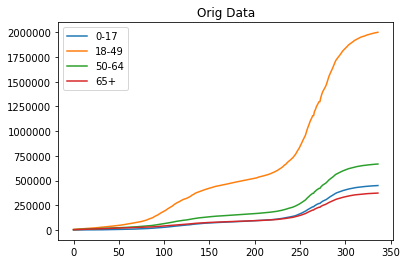

In [9]:
plt.plot(orig_beta_data)
plt.legend(orig_beta_data.columns)
plt.title('Orig Data')

### SIR data generation from 'orig_beta_data' and visualization 

We are considering recovery time <b>T_R = 5</b> days for calculating S_data, beta_data and R_data from orig_beta_data

In [10]:
T_R = 5 

In [11]:
R_data = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
R_data = R_data.rename(columns = lambda x: 'R'+ x)

R_data.values[T_R:,:] = orig_beta_data.values[:-T_R,:]

R_data_tilde = R_data/S_0


beta_data_tilde = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
beta_data_tilde = beta_data_tilde.rename(columns = lambda x: 'I'+ x)

old_beta_data_tilde = orig_beta_data/S_0

beta_data_tilde.values[:,:] = old_beta_data_tilde.values - R_data_tilde.values


S_data_tilde = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
S_data_tilde = S_data_tilde.rename(columns = lambda x: 'S'+ x)

S_data_tilde.values[:,:] = 1- beta_data_tilde.values - R_data_tilde.values

Text(0.5, 1.0, 'Orig first diff')

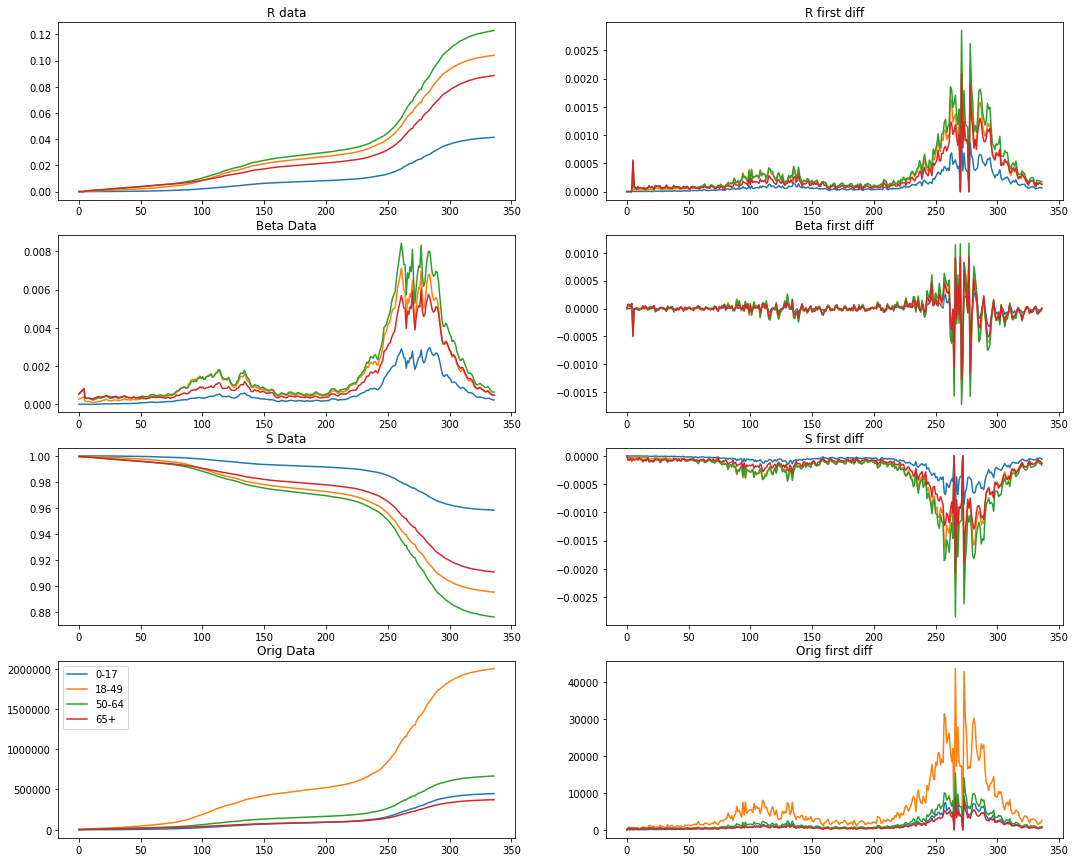

In [12]:
fig, axes = plt.subplots(nrows=4,ncols=2, figsize = (18,15))

axes[0,0].plot(R_data_tilde)
axes[0,0].set_title('R data')

axes[0,1].plot(R_data_tilde.diff().fillna(0))
axes[0,1].set_title('R first diff')

axes[1,0].plot(beta_data_tilde)
axes[1,0].set_title('Beta Data')

axes[1,1].plot(beta_data_tilde.diff().fillna(0))
axes[1,1].set_title('Beta first diff')

axes[2,0].plot(S_data_tilde)
axes[2,0].set_title('S Data')

axes[2,1].plot(S_data_tilde.diff().fillna(0))
axes[2,1].set_title('S first diff')

axes[3,0].plot(orig_beta_data)
axes[3,0].legend(orig_beta_data.columns)
axes[3,0].set_title('Orig Data')

axes[3,1].plot(orig_beta_data.diff().fillna(0))
axes[3,1].set_title('Orig first diff')


We need to smoothen these curves. 

In [13]:
window_length = 15

dataframe = orig_beta_data
first_diff = dataframe.diff().fillna(0)
smoothened_first_diff = first_diff.rolling(window_length,min_periods=1).mean()
smoothened_first_diff.iloc[0] = dataframe.iloc[0]
smoothened_final_data = smoothened_first_diff.cumsum()

#smoothened_final_data = orig_beta_data

R_data = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
R_data = R_data.rename(columns = lambda x: 'R'+ x)

R_data.values[T_R:,:] = smoothened_final_data.values[:-T_R,:]

R_data_tilde = R_data/S_0


beta_data_tilde = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
beta_data_tilde = beta_data_tilde.rename(columns = lambda x: 'I'+ x)

old_beta_data_tilde = smoothened_final_data/S_0

beta_data_tilde.values[:,:] = old_beta_data_tilde.values - R_data_tilde.values


S_data_tilde = pd.DataFrame().reindex_like(orig_beta_data).fillna(0)
S_data_tilde = S_data_tilde.rename(columns = lambda x: 'S'+ x)

S_data_tilde.values[:,:] = 1- beta_data_tilde.values - R_data_tilde.values

Text(0.5, 1.0, 'Orig first diff')

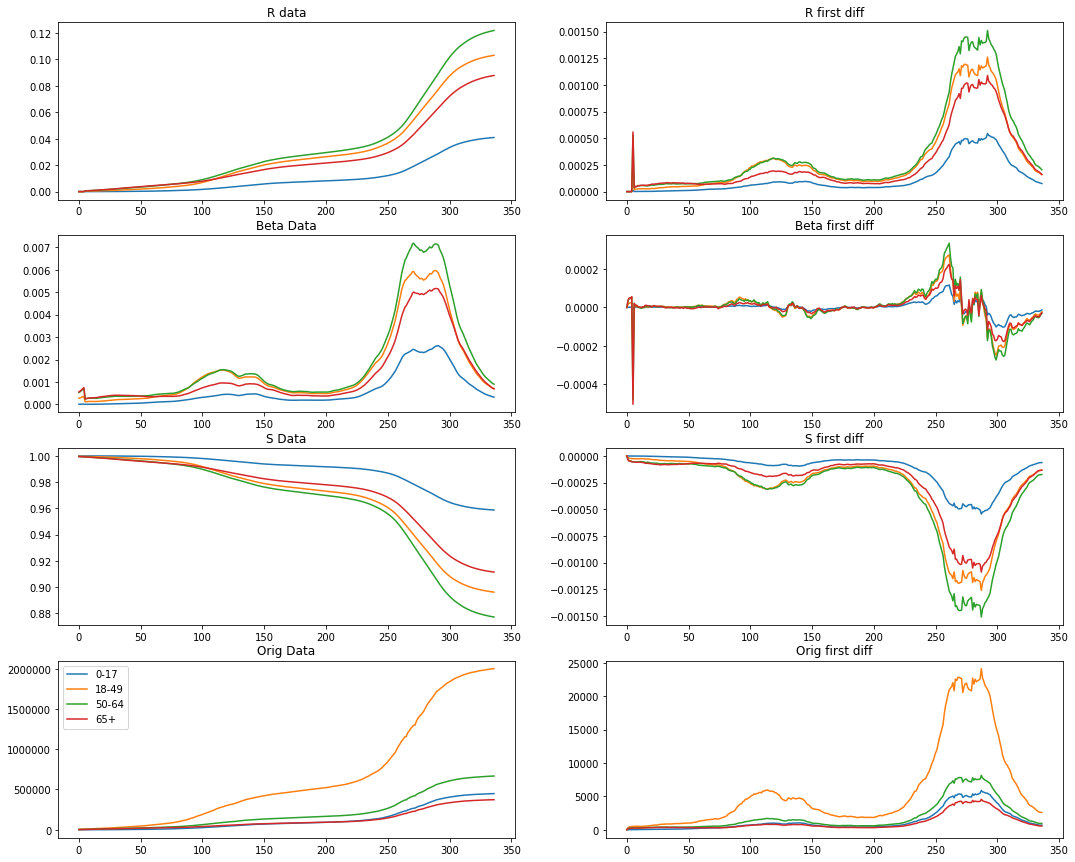

In [14]:
fig, axes = plt.subplots(nrows=4,ncols=2, figsize = (18,15))

axes[0,0].plot(R_data_tilde)
axes[0,0].set_title('R data')

axes[0,1].plot(R_data_tilde.diff().fillna(0))
axes[0,1].set_title('R first diff')

axes[1,0].plot(beta_data_tilde)
axes[1,0].set_title('Beta Data')

axes[1,1].plot(beta_data_tilde.diff().fillna(0))
axes[1,1].set_title('Beta first diff')

axes[2,0].plot(S_data_tilde)
axes[2,0].set_title('S Data')

axes[2,1].plot(S_data_tilde.diff().fillna(0))
axes[2,1].set_title('S first diff')

axes[3,0].plot(orig_beta_data)
axes[3,0].legend(smoothened_final_data.columns)
axes[3,0].set_title('Orig Data')

axes[3,1].plot(smoothened_final_data.diff().fillna(0))
axes[3,1].set_title('Orig first diff')


We can see, smoothed data is looks good and we can use this data for parameter estimation and SIR data generation

## Parameter estimation, SIR data and loss/error generation

Define phases to be considered:

In [15]:
phase_1 = range(0,65)
phase_2 = range(65,110)
phase_3 = range(110,160)
phase_4 = range(160,215)
phase_5 = range(215,270)
phase_6 = range(270,300)
phase_7 = range(300,len(orig_beta_data))
phases = [phase_1,phase_2,phase_3,phase_4,phase_5,phase_6,phase_7]


In [23]:
param_loss_tr_dict_multiplication_fact = {}

factor_range = range(1,2,1)
T_R_range = range(14,15,1)

### This window length is for smoothening actual california data
window_length = 15
### we don't need this in case of simulated data for any state

for factor in factor_range:
    
    dataframe = orig_beta_data * factor
    param_loss_tr_dict = {}

    for T_R in T_R_range:
        
        #################################################################################
        ## We are calling SIR_Data_with_T_R function in object created by StateData class 
        ## to get S,I,R dataframes 
        
        S_data, beta_data, R_data = Cal_data.SIR_Data_with_T_R(orig_beta_data,
                                                               T_R, 
                                                               S_0, 
                                                               population,
                                                               smoothing = True, 
                                                               undetected_fact = False, 
                                                               window_length = window_length )
        
        #################################################################################
        ## We are calling get_params_and_generated_data function in object created by StateData class 
        ## to get parameters and generated data 
        
        A_No_int_nn_list, Gamma_nn_list, S_data_gen, beta_data_gen, R_data_gen \
                = Cal_data.get_params_and_generated_data(S_data, 
                                                         beta_data, 
                                                         R_data, 
                                                         phases, T_R)
        
        #################################################################################
        ## We are using sum of square of differences as our loss
        
        loss_S_data =  np.sum((S_data.iloc[T_R+1:].values - S_data_gen.iloc[T_R+1:].values)**2)/factor**2
        loss_beta_data =  np.sum((beta_data.iloc[T_R+1:].values - beta_data_gen.iloc[T_R+1:].values)**2)/factor**2
        loss_R_data =  np.sum((R_data.iloc[T_R+1:].values - R_data_gen.iloc[T_R+1:].values)**2)/factor**2
        
        loss = loss_S_data + loss_beta_data +loss_R_data
        
        #################################################################################
        ## Printitng losses 
        
        print('loss for '+str(T_R)+' days of recovery and multiplication factor is '+str(factor))
        print('loss is '+str(loss))
        print('S_data loss is '+str(loss_S_data))
        print('beta_data loss is '+str(loss_beta_data))
        print('R_data loss is '+str(loss_R_data))
        print('\n')
        
        #################################################################################
        ## Storing initial data, parameters, generated data and losses for given T_R in a dictionary
        
        param_loss_tr_dict[T_R] = {
                                    'A_No_int_nn':A_No_int_nn_list,
                                   'Gamma_nn':Gamma_nn_list,
                                   
                                   'loss':loss,
                                   'loss_S_data':loss_S_data,
                                   'loss_beta_data':loss_beta_data,
                                   'loss_R_data':loss_R_data,
                                   
                                   'S_data':S_data,
                                   'beta_data':beta_data,
                                   'R_data':R_data,
                                   
                                   'S_data_gen':S_data_gen,
                                   'beta_data_gen':beta_data_gen,
                                   'R_data_gen':R_data_gen
                                  }
    
    #################################################################################
    ## Storing dictionary generated for given factor value
    param_loss_tr_dict_multiplication_fact[factor] = param_loss_tr_dict


start_date, end_date for a phase
15 64
Max, Min in A matrix
0.6850707505015418 0.0
start_date, end_date for a phase
65 109
Max, Min in A matrix
0.9496563201918495 0.0
start_date, end_date for a phase
110 159
Max, Min in A matrix
0.151447801106908 0.0
start_date, end_date for a phase
160 214
Max, Min in A matrix
0.7646251102756814 0.0
start_date, end_date for a phase
215 269
Max, Min in A matrix
0.23159623280264963 0.0
start_date, end_date for a phase
270 299
Max, Min in A matrix
0.19206296804827253 0.0
start_date, end_date for a phase
300 336
Max, Min in A matrix
0.15363080596089015 0.0
loss for 14 days of recovery and multiplication factor is 1
loss is 7.1356456188097e-05
S_data loss is 4.049719058000611e-05
beta_data loss is 1.4578550276402192e-05
R_data loss is 1.6280715331688692e-05




In [24]:
key_to_minimize = 'loss'
min_factor = 1
min_index = 0
min_loss = 0
count = 0
for key in param_loss_tr_dict_multiplication_fact.keys():
    param_loss_tr_dict = param_loss_tr_dict_multiplication_fact[key]
    for i in param_loss_tr_dict.keys():
        print(key, i, param_loss_tr_dict[i][key_to_minimize], param_loss_tr_dict[i]['loss_S_data'])
        if(count == 0):
            min_loss = param_loss_tr_dict[i][key_to_minimize]
            min_index=i
            min_factor = key
            count+=1
        elif(param_loss_tr_dict[i][key_to_minimize]<min_loss):
            min_loss = param_loss_tr_dict[i][key_to_minimize]
            min_index = i
            min_factor = key

print("\n")
print("Mul_factor, Recovery time, Overall loss")
print(min_factor, min_index, min_loss)

1 14 7.1356456188097e-05 4.049719058000611e-05


Mul_factor, Recovery time, Overall loss
1 14 7.1356456188097e-05


Exploring in the data that we saved above, we found out that we have minimum overall loss for multiplication factor 1 and recovery time 4 days.

#### Visualizing data generated by age-structured SIR model with respect to base data

In [25]:
param_loss_tr_dict = param_loss_tr_dict_multiplication_fact[min_factor]

In [26]:
####### Getting beta_data and beta_data_gen for minimum loss

beta_data_min_loss = param_loss_tr_dict[min_index]['beta_data']
beta_data_gen_min_loss = param_loss_tr_dict[min_index]['beta_data_gen']

beta_data_min_loss = beta_data_min_loss*population
beta_data_gen_min_loss = beta_data_gen_min_loss*population

beta_data_min_loss = beta_data_min_loss.astype('int64')
beta_data_gen_min_loss = beta_data_gen_min_loss.astype('int64')

####### Getting S_data and S_data_gen for minimum loss

S_data_min_loss = param_loss_tr_dict[min_index]['S_data']
S_data_gen_min_loss = param_loss_tr_dict[min_index]['S_data_gen']

S_data_min_loss = S_data_min_loss*population
S_data_gen_min_loss = S_data_gen_min_loss*population

S_data_min_loss = S_data_min_loss.astype('int64')
S_data_gen_min_loss = S_data_gen_min_loss.astype('int64')

####### Getting R_data and R_data_gen for minimum loss

R_data_min_loss = param_loss_tr_dict[min_index]['R_data']
R_data_gen_min_loss = param_loss_tr_dict[min_index]['R_data_gen']

R_data_min_loss = R_data_min_loss*population
R_data_gen_min_loss = R_data_gen_min_loss*population

R_data_min_loss = R_data_min_loss.astype('int64')
R_data_gen_min_loss = R_data_gen_min_loss.astype('int64')

In [27]:
start_date = min_index + 1
phase = range(start_date,phases[-1][-1])
phase

range(15, 336)

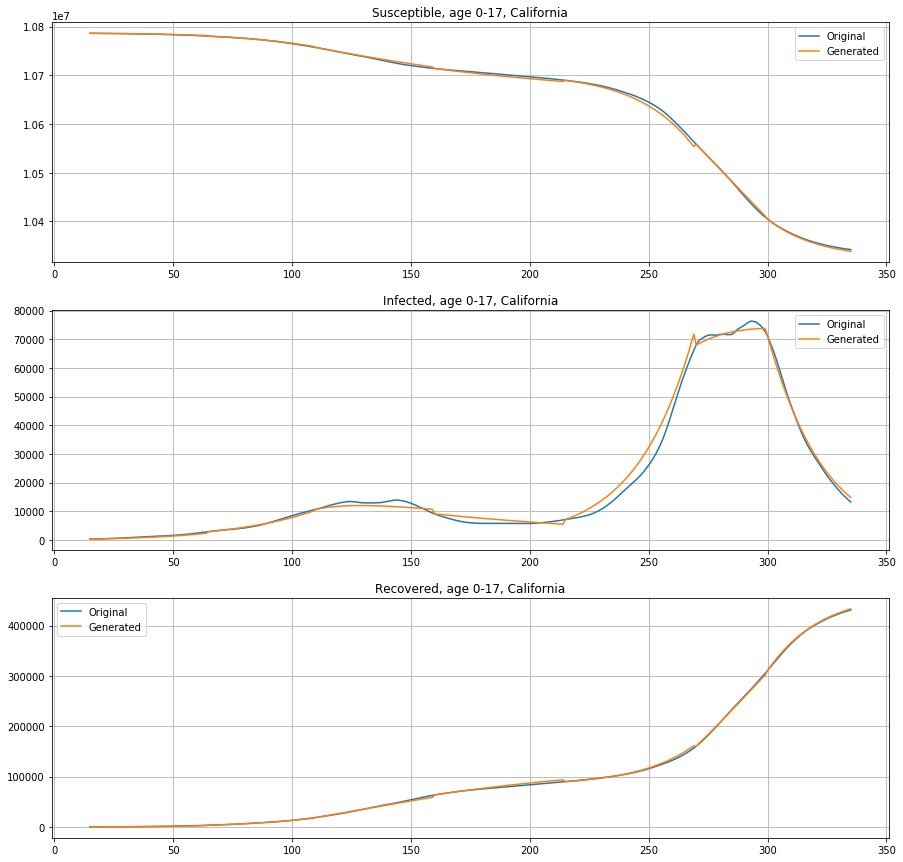

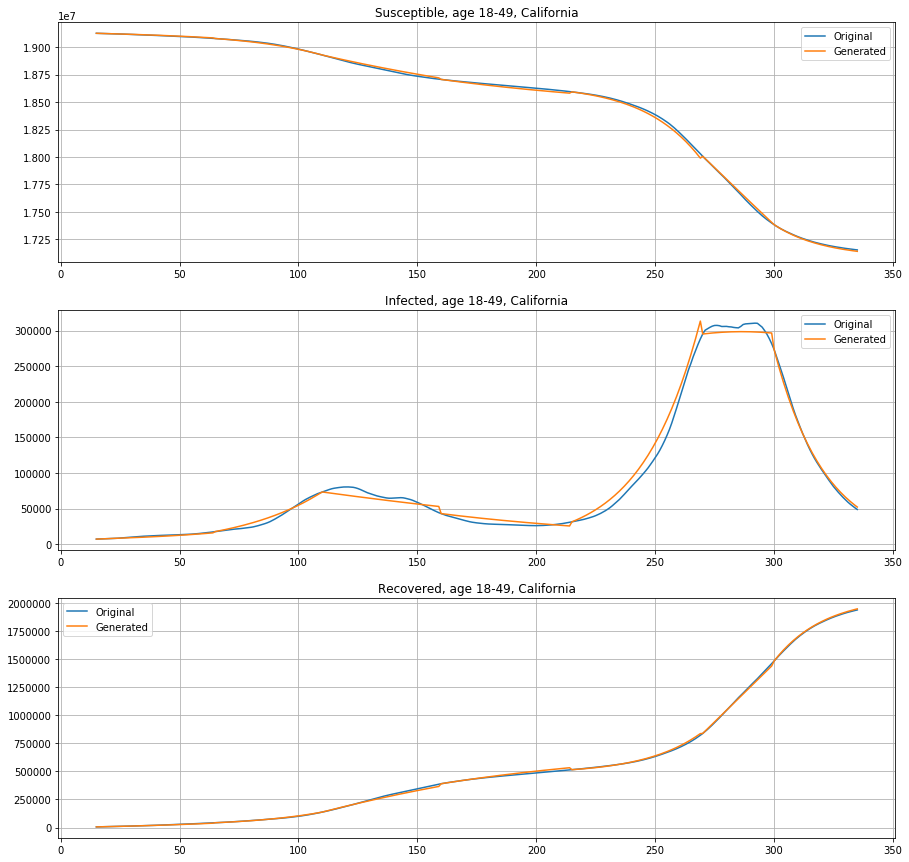

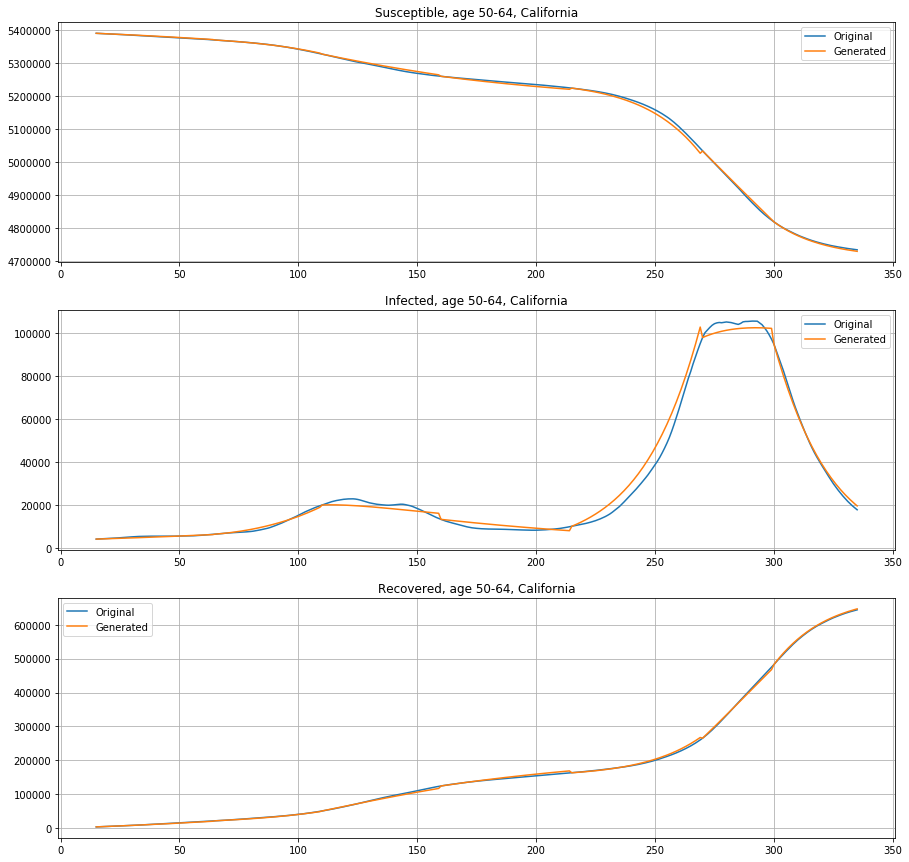

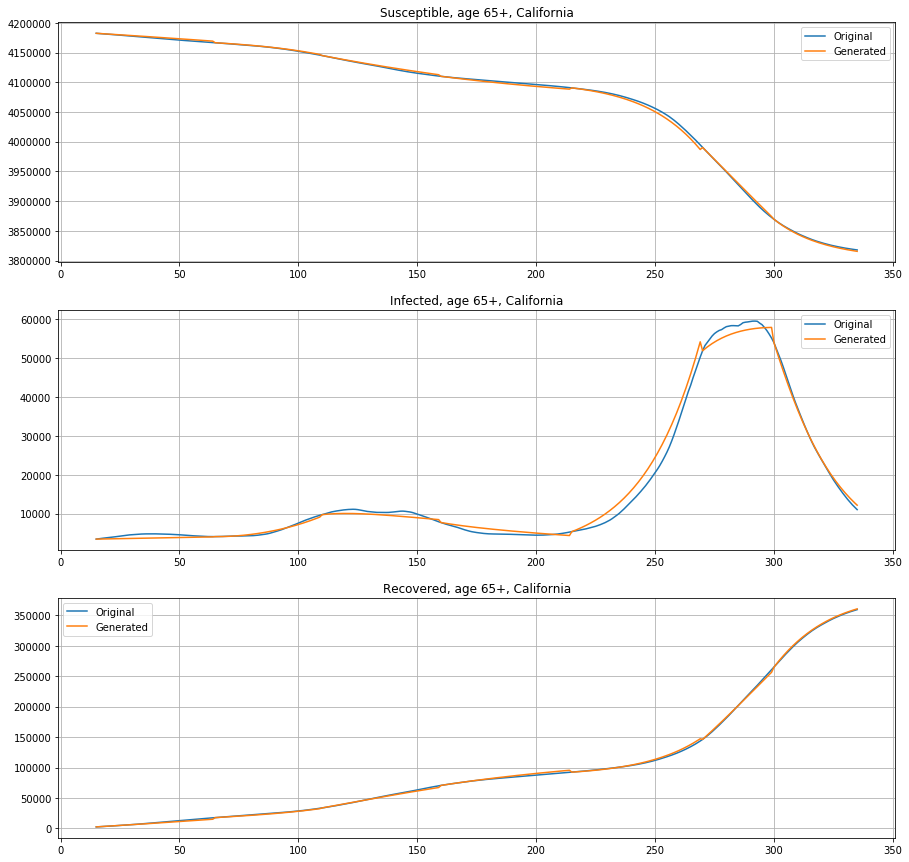

In [28]:
set_of_age_groups = column_names

for age_group in  set_of_age_groups:

    fig, ax = plt.subplots(3,1,figsize=(15,15))

    ax[0].plot(S_data_min_loss['S'+age_group].iloc[phase],label='Original')
    ax[0].plot(S_data_gen_min_loss['S'+age_group].iloc[phase], label='Generated')
    ax[0].legend()
    ax[0].grid(True)
    ax[0].set_title('Susceptible, age '+ age_group+", "+state_name)

    ax[1].plot(beta_data_min_loss['I'+age_group].iloc[phase],label='Original')
    ax[1].plot(beta_data_gen_min_loss['I'+age_group].iloc[phase], label='Generated')
    ax[1].legend()
    ax[1].grid(True)
    ax[1].set_title('Infected, age '+ age_group+", "+state_name)

    ax[2].plot(R_data_min_loss['R'+age_group].iloc[phase],label='Original')
    ax[2].plot(R_data_gen_min_loss['R'+age_group].iloc[phase], label='Generated')
    ax[2].legend()
    ax[2].grid(True)
    ax[2].set_title('Recovered, age '+ age_group+", "+state_name)

In [22]:
param_loss_tr_dict

{14: {'A_No_int_nn': [array([[0.32014545, 0.        , 0.00504011, 0.        ],
          [0.50281031, 0.        , 0.25533549, 0.        ],
          [0.01915388, 0.        , 0.56907053, 0.        ],
          [0.        , 0.        , 0.        , 0.70991616]]),
   array([[0.07171285, 0.        , 0.        , 0.22943439],
          [0.99450278, 0.02064186, 0.        , 0.        ],
          [0.54487644, 0.        , 0.        , 0.64637924],
          [0.        , 0.        , 0.        , 0.78538331]]),
   array([[0.        , 0.        , 0.14694721, 0.        ],
          [0.        , 0.14808085, 0.        , 0.        ],
          [0.        , 0.15976487, 0.        , 0.        ],
          [0.        , 0.06444784, 0.        , 0.24140589]]),
   array([[0.2415115 , 0.        , 0.        , 0.        ],
          [0.75898479, 0.        , 0.        , 0.        ],
          [0.86852225, 0.        , 0.        , 0.        ],
          [0.58281459, 0.        , 0.        , 0.        ]]),
   array([[0.